In [1]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    # 実行されないようにセルの内容を無視する
    print(f"Skipping cell:\n{cell}")

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import requests
import urllib
import unicodedata
from statistics import mean,pstdev
from datetime import datetime,timedelta
#import jpholiday
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from itertools import product
from typing import Union
import japanize_matplotlib
import seaborn
#import sweetviz as sv
import lightgbm as lgb
import catboost 
from catboost import cv,CatBoostClassifier,CatBoostRegressor, Pool
import xgboost as xgb
#import category_encoders
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,StratifiedGroupKFold,TimeSeriesSplit,cross_val_score,GroupKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import PartialDependenceDisplay

from collections import Counter
from imblearn.over_sampling import SMOTE,SMOTENC

from scipy.optimize import minimize
#from prophet import Prophet
#from prophet.diagnostics import performance_metrics,cross_validation
#from prophet.plot import add_changepoints_to_plot
#from neuralprophet import NeuralProphet
import optuna
#from optuna.integration import OptunaSearchCV
import webbrowser
from geopy.geocoders import Nominatim,Photon
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
from geolib import geohash
#from normalize_japanese_addresses import normalize
import folium
import geopandas
import tqdm
from tqdm import tqdm_notebook

import requests
import urllib.parse
import re
import json
import joblib
import gc

TARGET="target"

cols=['価格情報区分', '都道府県名', '市区町村名', '地区名', '住所不一致_Flag', '住所', '最寄駅：名称',
       '最寄駅：距離（分）', '徒歩時間_10分単位', '間取り',
       '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）',
       '取引時点', '改装', '取引の事情等', '取引価格（総額）_log', '単位面積あたりの取引価格_log', '建築西暦年',
       '築年数', 'log_面積（㎡）', '購入までの築年数', 
       '旧耐震フラグ', '最寄駅までの距離','target', 'pred_tg_lgbm', 'pred_lgbm', 'pred_cat', 'pred_weight',
       'target_price', 'mae']

def check_dataframe_elements(df):
    df.info()
    print("マルチインデックス=>",isinstance(df.index,pd.MultiIndex))
    print(df.shape)
    print("-----カラム名一覧-----")
    print(df.columns)
    for col in df.columns.to_list():
        print(f"-----{col}-----に含まれるユニークな値の数")
        print(df[col].nunique())
        print(f"-----{col}-----に含まれる値を被り無しで表示")
        print(df[col].unique())

In [3]:
oof_df=pd.read_csv("oof_full_df.csv")
oof_df=oof_df.set_index("ID")

oof_df=oof_df.drop(["target.1","target"],axis=1)
oof_df=oof_df.rename(columns={"target_tg":"target"})

In [4]:
check_dataframe_elements(oof_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009271 entries, 1046933 to 47011639
Data columns (total 66 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   価格情報区分                 1009271 non-null  object 
 1   都道府県名                  1009271 non-null  object 
 2   市区町村名                  1009271 non-null  object 
 3   地区名                    1009206 non-null  object 
 4   住所不一致_Flag             1009271 non-null  int64  
 5   住所                     1009271 non-null  object 
 6   最寄駅：名称                 1009220 non-null  object 
 7   最寄駅：距離（分）              964322 non-null   float64
 8   徒歩時間_10分単位             964322 non-null   float64
 9   x_api                  1009220 non-null  float64
 10  y_api                  1009220 non-null  float64
 11  lon                    998562 non-null   float64
 12  lat                    998562 non-null   float64
 13  間取り                    976570 non-null   object 
 14  面積（㎡）      

In [5]:
df_corr=oof_df.corr()
df_corr

C:\Users\yuto2\AppData\Local\Temp\ipykernel_44888\3034528542.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr=oof_df.corr()


,住所不一致_Flag,最寄駅：距離（分）,徒歩時間_10分単位,x_api,y_api,lon,lat,面積（㎡）,建ぺい率（％）,容積率（％）,...,県_市_geohash_5_駅徒歩時間平均,県_市_geohash_5_建築年平均,県_市_geohash_6_駅徒歩時間平均,県_市_geohash_6_建築年平均,県_市_geohash_7_駅徒歩時間平均,県_市_geohash_7_建築年平均,target,pred_tg_lgbm,pred_lgbm,pred_cat
住所不一致_Flag,1.000000,-0.020968,-0.020646,-0.054412,-0.022959,-0.056740,-0.026981,-0.036070,0.075703,0.103435,...,-0.035795,0.030827,-0.030071,0.026368,-0.024715,0.024106,0.003009,0.002027,0.002261,0.001796
最寄駅：距離（分）,-0.020968,1.000000,0.973613,-0.071305,-0.006174,-0.069233,-0.008046,0.132492,-0.299224,-0.319329,...,0.728681,-0.219983,0.878361,-0.224176,0.893865,-0.206636,-0.236624,-0.247294,-0.246614,-0.248750
徒歩時間_10分単位,-0.020646,0.973613,1.000000,-0.067691,-0.004305,-0.065343,-0.005670,0.129555,-0.277551,-0.295882,...,0.716177,-0.211819,0.859277,-0.215033,0.873276,-0.198091,-0.228272,-0.238602,-0.238022,-0.240246
x_api,-0.054412,-0.071305,-0.067691,1.000000,0.635566,0.911342,0.526771,-0.085865,-0.064108,0.005485,...,-0.099229,0.030662,-0.087130,0.020862,-0.085824,0.019230,0.189827,0.201804,0.201491,0.201022
y_api,-0.022959,-0.006174,-0.004305,0.635566,1.000000,0.577856,0.879648,0.027125,-0.004055,-0.021212,...,-0.010453,-0.101925,-0.013522,-0.069654,-0.013382,-0.062377,-0.041150,-0.041708,-0.041772,-0.042627
lon,-0.056740,-0.069233,-0.065343,0.911342,0.577856,1.000000,0.631101,-0.073952,-0.061591,0.002304,...,-0.088322,0.026719,-0.075314,0.013242,-0.073973,0.011222,0.171695,0.182516,0.182264,0.181765
lat,-0.026981,-0.008046,-0.005670,0.526771,0.879648,0.631101,1.000000,0.035015,-0.010693,-0.022868,...,-0.004198,-0.095857,-0.006257,-0.066384,-0.005776,-0.059246,-0.043037,-0.043885,-0.043858,-0.044788
面積（㎡）,-0.036070,0.132492,0.129555,-0.085865,0.027125,-0.073952,0.035015,1.000000,-0.255021,-0.281883,...,0.157451,-0.108689,0.152314,-0.028858,0.152411,-0.004248,0.373748,0.395783,0.403210,0.397515
建ぺい率（％）,0.075703,-0.299224,-0.277551,-0.064108,-0.004055,-0.061591,-0.010693,-0.255021,1.000000,0.767827,...,-0.222319,0.253265,-0.279820,0.221901,-0.289236,0.205642,0.033545,0.033994,0.034055,0.035279
容積率（％）,0.103435,-0.319329,-0.295882,0.005485,-0.021212,0.002304,-0.022868,-0.281883,0.767827,1.000000,...,-0.281150,0.356607,-0.311850,0.281281,-0.318959,0.257821,0.120951,0.126873,0.126415,0.127325


In [6]:
#print(abc)

In [7]:
def mae_loss_fn(true_targets,pred_weighted):
    return mean_absolute_error(true_targets,pred_weighted)

class WeightsSearcher:
    def __init__(self,loss_fn,bounds=[],mode="min",method="SLSQP"):
        self.loss_fn=loss_fn#損失関数
        self.bounds=bounds#重みの範囲
        self.mode=mode#最適化モード(minまたはmax)
        self.method=method#最適化方法(デフォルトは"SLSQP")

    # 目的関数のラッパー: 予測値、真のターゲット、目的関数を受け取り、重み付けされた予測値を計算する関数を返す
    def _objective_function_wrapper(self,pred_values,true_targets,obj_fn):
        def objective_function(weights):
            #print(pred_values)
            #予測値に重みを適用し、行ごとに合計
            pred_weighted=(pred_values*weights).sum(axis=1)
            #真のターゲットと重み付けされた予測値を使用してスコアを計算
            score = obj_fn(true_targets, pred_weighted)
            # 最適化モードに応じてスコアを反転
            return score if self.mode == "min" else score
        #目的関数を返す
        return objective_function

    #最適な重みを見つけるメソッド:検証予測値と真のターゲットを受け取り、最適化を実行
    def find_weights(self, val_preds, true_targets):
        len_models = len(self.bounds)#モデルの数を取得
        bounds = [0,1] * len_models if len(self.bounds) == 0 else self.bounds# 重みの範囲が指定されていない場合は [0,1] の範囲を設定
        ##np.ones は、指定された形状とデータ型で、すべての要素が1である新しい配列を生成するNumPy関数です。
        ##len_models はモデルの数を表しており、この数だけ1が含まれた配列が作成されます。
        ##例えば、len_models が3の場合、np.ones(len_models) は [1, 1, 1] という配列を生成します。
        ###initial_weights = np.ones(len_models) / len_models# 初期重みを設定（各モデルに等しい重み）
        initial_weights = np.random.rand(len_models)  # 初期重みをランダムに設定
        initial_weights /= np.sum(initial_weights)  # 初期重みを正規化
        objective_function = self._objective_function_wrapper(val_preds, true_targets, self.loss_fn)#目的変数をラップ

        # 制約条件: 重みの合計が1になるようにする
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        result = minimize(
            objective_function,
            initial_weights,
            bounds=bounds,
            method=self.method,
            constraints=constraints
        )
        #最適化された重みを取得
        optimized_weights = result.x
        #重みの合計が1になるように正規化
        optimized_weights /= np.sum(optimized_weights)
        #最適化された重みを返す
        return optimized_weights

#pred_cols=["pred_cat","pred_lgbm"]
pred_cols=["pred_cat","pred_lgbm","pred_tg_lgbm"]
#pred_cols=["pred_cat","pred_lgbm","pred_xg"]
#model_names=["cat","lgbm"]
model_names=["cat","lgbm","tg_lgbm"]
#model_names=["cat","lgbm","xg"]

#それぞれのモデルの予測値の範囲を設定
bounds=[(0,1)]*len(pred_cols)
print(bounds)
# ROC AUCスコアの補数を計算する関数
mae_loss_fn=lambda y_true, y_pred:mean_absolute_error(y_true,y_pred)

w_searcher = WeightsSearcher(mae_loss_fn, bounds
                             ,method='Nelder-Mead'
                             #,method="L-BFGS-B"
                             #,method='COBYLA'
                             ) # log_loss, gini_stability roc_auc_fn
optimized_weights = w_searcher.find_weights(
    oof_df[pred_cols].to_numpy(),
    oof_df[f"{TARGET}"]
)

optimized_weights_df = pd.DataFrame(zip(model_names, optimized_weights), columns=['model', 'weight'])
display(optimized_weights_df)
print("sum: ", np.sum(optimized_weights))

#-----------------
train_preds_df=oof_df.copy()
train_preds_df["pred_weight"]=(optimized_weights*train_preds_df[pred_cols]).sum(axis=1).to_numpy()
#display(train_preds_df)

# 重みを取得
weights = optimized_weights_df.set_index('model')['weight'].to_dict()

mae=mean_absolute_error(train_preds_df["target"],train_preds_df["pred_weight"])
print("MAE:",mae)
print("cat_weight:",weights["cat"])
print("lgbm_weight:",weights["lgbm"])
print("lgbm_tg_weight:",weights["tg_lgbm"])

[(0, 1), (0, 1), (0, 1)]


c:\Users\yuto2\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


,model,weight
0,cat,0.414737
1,lgbm,0.332685
2,tg_lgbm,0.252577


sum:  0.9999999999999998
MAE: 0.06483274074998932
cat_weight: 0.41473713282282126
lgbm_weight: 0.3326854230878754
lgbm_tg_weight: 0.2525774440893032


model	weight
0	cat	0.414725
1	lgbm	0.332699
2	tg_lgbm	0.252575

In [8]:
%%skip

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ダミーデータの作成
np.random.seed(0)
train_preds_df = pd.DataFrame({
    'target': np.random.uniform(0, 5, 1000),
    'pred_weight': np.random.uniform(0, 5, 1000)
})

# 計算部分
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# ランキングの計算
train_preds_df['mae_price_rank'] = train_preds_df['mae_price'].rank(method='min', ascending=True)

# ランキングの正規化
scaler = MinMaxScaler()
train_preds_df['mae_price_rank_normalized'] = scaler.fit_transform(train_preds_df[['mae_price_rank']])

# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)

# プロット1: ランキングを色に使用
sns.scatterplot(
    ax=axes[0],
    x='target',
    y='mae',
    hue='mae_price_rank',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)
axes[0].set_title('mae_priceのランキングで色分け', fontsize=16)
axes[0].set_xlabel('目的変数 (target)', fontsize=14)
axes[0].set_ylabel('MAE (対数スケール)', fontsize=14)
axes[0].legend(title='mae_price Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# プロット2: 正規化されたランキングを色に使用
scatter = sns.scatterplot(
    ax=axes[1],
    x='target',
    y='mae',
    hue='mae_price_rank_normalized',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)
axes[1].set_title('mae_priceの正規化ランキングで色分け', fontsize=16)
axes[1].set_xlabel('目的変数 (target)', fontsize=14)
axes[1].set_ylabel('MAE (対数スケール)', fontsize=14)
axes[1].legend([], [], frameon=False)
axes[1].grid(True)

# カラーバーの追加（正規化されたランキングのみ）
norm = plt.Normalize(train_preds_df['mae_price_rank_normalized'].min(), train_preds_df['mae_price_rank_normalized'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('mae_price ランキング（正規化）', fontsize=12)
cbar_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
cbar.set_ticks(cbar_ticks)
max_rank = train_preds_df['mae_price_rank'].max()
cbar_tick_labels = [f"{int(tick * max_rank)}" for tick in cbar_ticks]
cbar.set_ticklabels(cbar_tick_labels)

plt.tight_layout()
plt.show()


Skipping cell:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ダミーデータの作成
np.random.seed(0)
train_preds_df = pd.DataFrame({
    'target': np.random.uniform(0, 5, 1000),
    'pred_weight': np.random.uniform(0, 5, 1000)
})

# 計算部分
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# ランキングの計算
train_preds_df['mae_price_rank'] = train_preds_df['mae_price'].rank(method='min', ascending=True)

# ランキングの正規化
scaler = MinMaxScaler()
train_preds_df['mae_price_rank_normalized'] = scaler.fit_transform(train_preds_df[['mae_price_rank']])

# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)


Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...  pred_tg_lgbm  pred_lgbm  \
ID                                          ...                            
1046933        4.0         0.0  141.396484  ...      7.214925   7.232717   
1079053       11.0        10.0  141.297836  ...      7.156613   7.081142   
1170588        NaN         NaN  141.500595  ...      7.000789   6.978727   
1001637        6.0         0.0  141.354538  ...      

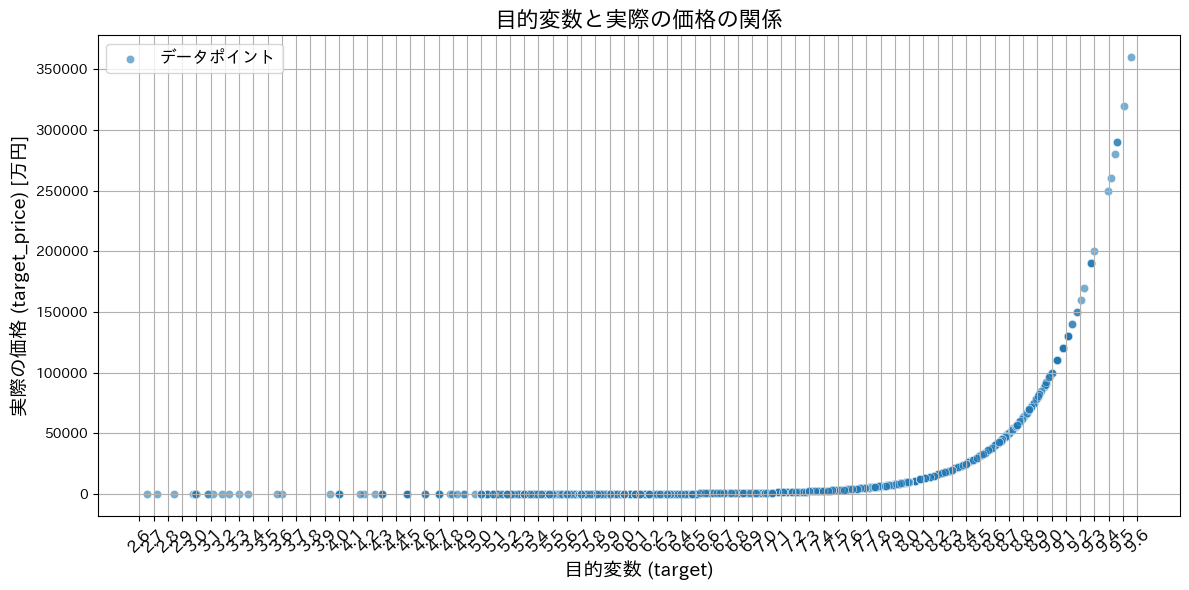

C:\Users\yuto2\AppData\Local\Temp\ipykernel_44888\2959740140.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


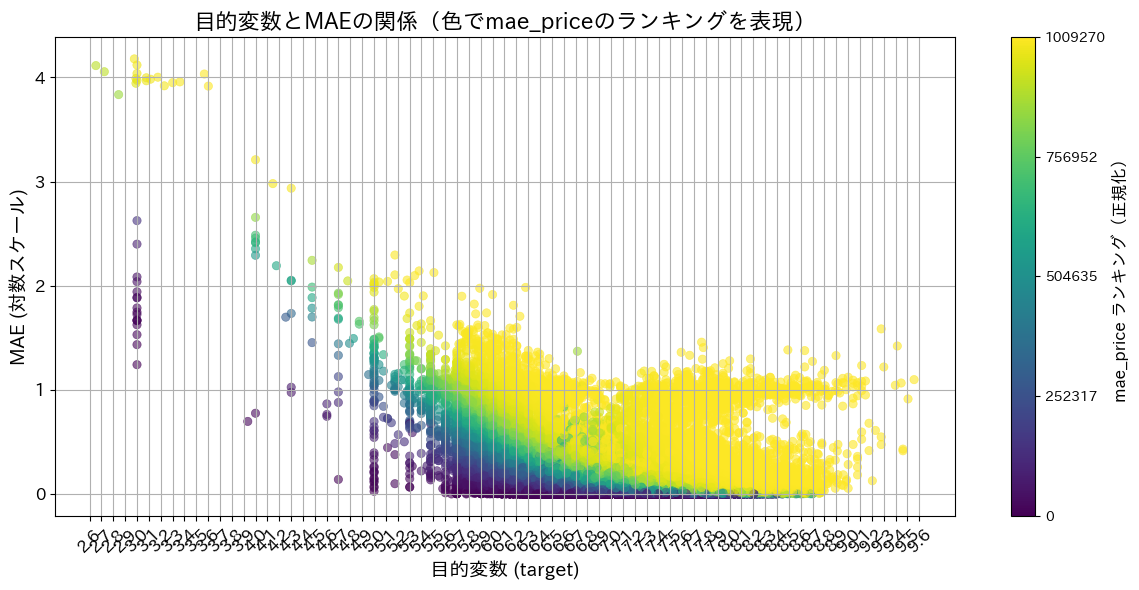

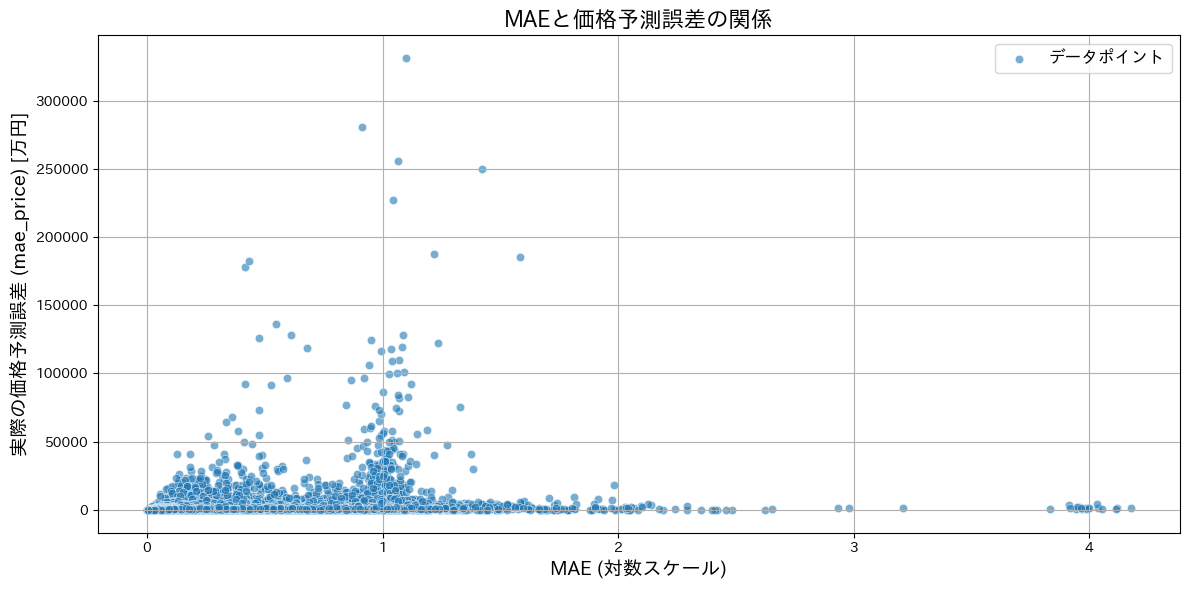

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as mticker


# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# mae_priceのランキングを計算（同じ値は同じランク）
train_preds_df['mae_price_rank'] = train_preds_df['mae_price'].rank(method='min', ascending=True)

# ランキングを正規化
scaler = MinMaxScaler()
train_preds_df['mae_price_rank_normalized'] = scaler.fit_transform(train_preds_df[['mae_price_rank']])

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係', fontsize=16)
plt.xlabel('目的変数 (target)', fontsize=14)
plt.ylabel('実際の価格 (target_price) [万円]', fontsize=14)
plt.xticks(x_ticks, rotation=45, fontsize=12)  # ラベルを45度回転し、フォントサイズを調整
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化（mae_priceのランキングに基づく色分け）
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='target',
    y='mae',
    hue='mae_price_rank_normalized',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)

plt.title('目的変数とMAEの関係（色でmae_priceのランキングを表現）', fontsize=16)
plt.xlabel('目的変数 (target)', fontsize=14)
plt.ylabel('MAE (対数スケール)', fontsize=14)
plt.xticks(x_ticks, rotation=45, fontsize=12)  # ラベルを45度回転し、フォントサイズを調整

# カラーバーの追加
norm = plt.Normalize(train_preds_df['mae_price_rank_normalized'].min(), train_preds_df['mae_price_rank_normalized'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('mae_price ランキング（正規化）', fontsize=12)

# カラーバーの目盛りをランキングに基づいてカスタマイズ
cbar_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
cbar.set_ticks(cbar_ticks)
max_rank = train_preds_df['mae_price_rank'].max()
cbar_tick_labels = [f"{int(tick * max_rank)}" for tick in cbar_ticks]
cbar.set_ticklabels(cbar_tick_labels)

plt.yticks(fontsize=12)
plt.legend([], [], frameon=False)  # 凡例を非表示にする（色のスケールのみ表示）
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係', fontsize=16)
plt.xlabel('MAE (対数スケール)', fontsize=14)
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#print(abc)

In [11]:
#print(abc)

Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...  pred_tg_lgbm  pred_lgbm  \
ID                                          ...                            
1046933        4.0         0.0  141.396484  ...      7.214925   7.232717   
1079053       11.0        10.0  141.297836  ...      7.156613   7.081142   
1170588        NaN         NaN  141.500595  ...      7.000789   6.978727   
1001637        6.0         0.0  141.354538  ...      

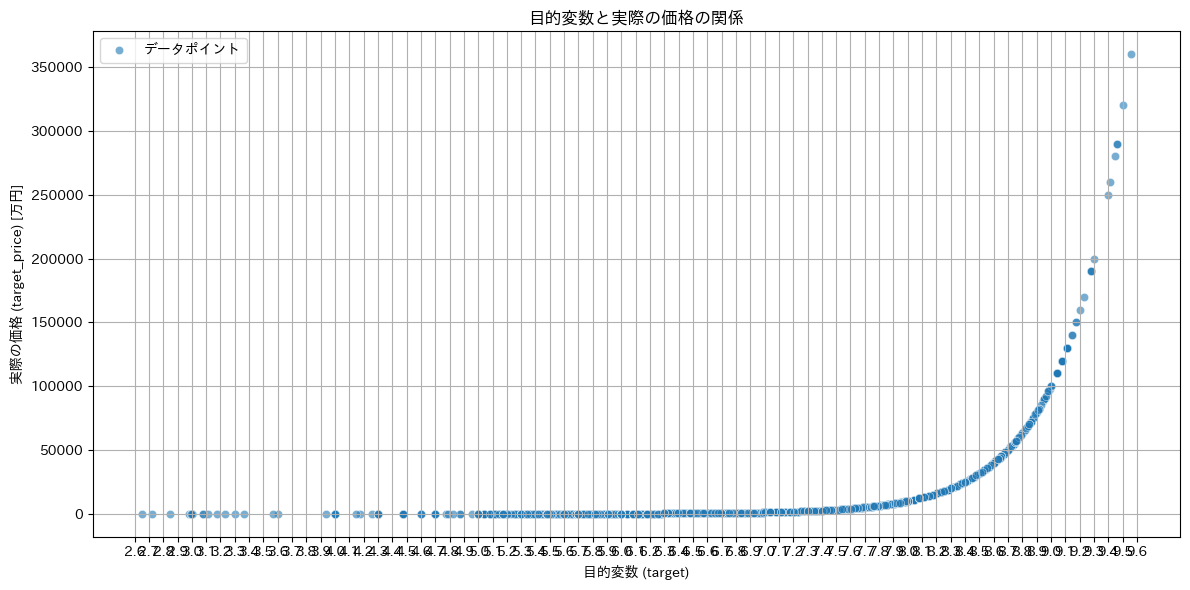

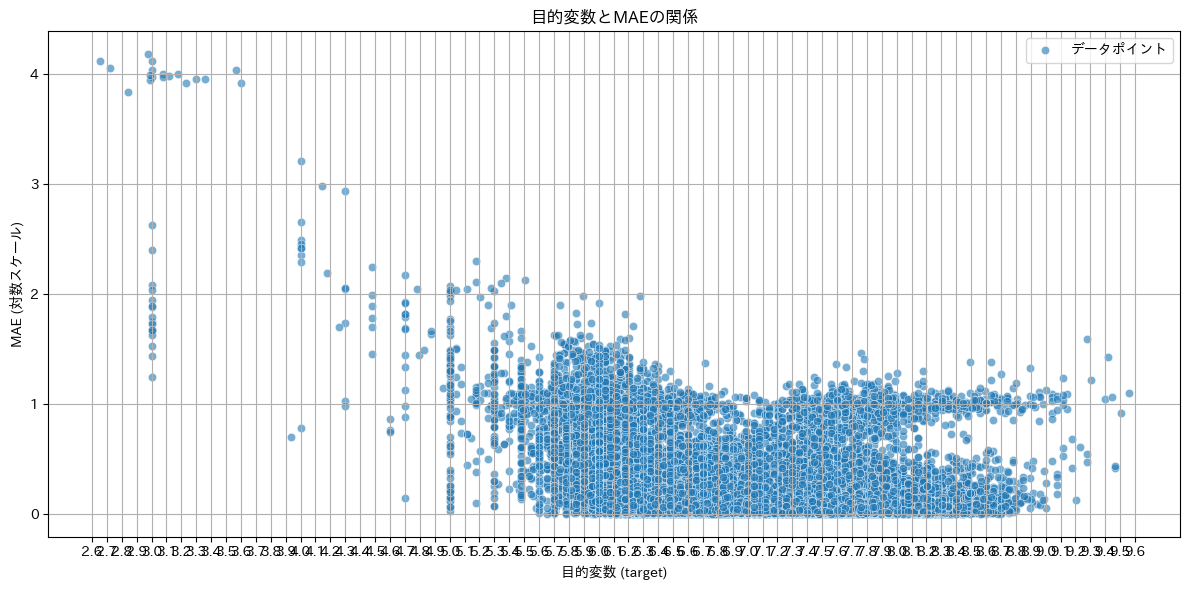

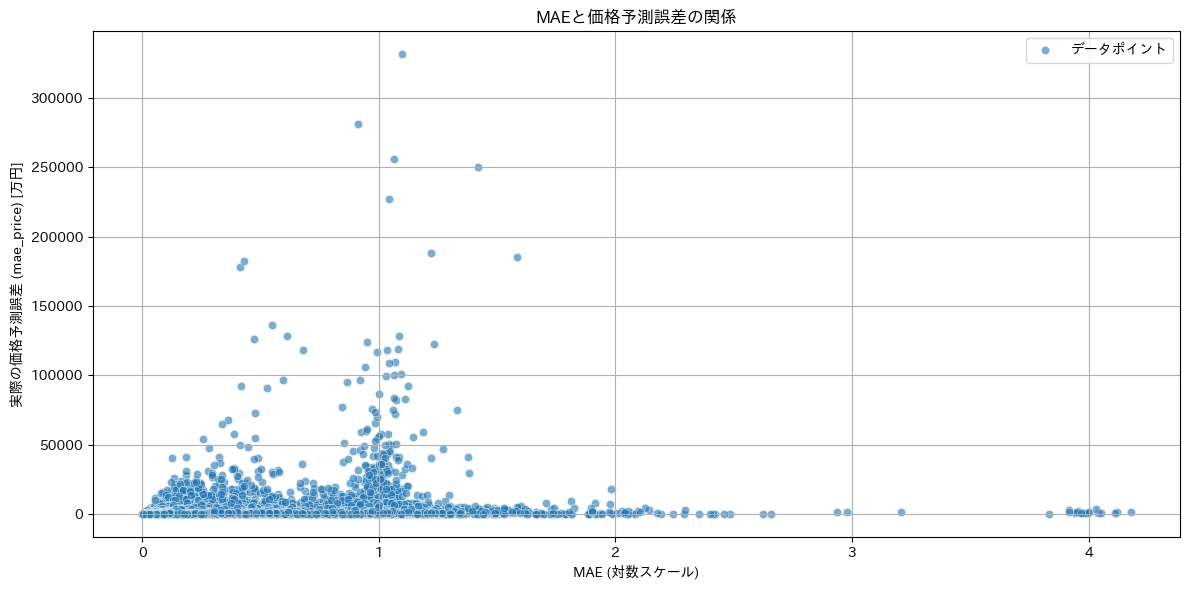

In [12]:
# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（対数スケール）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算（pred_weightがlog10(price)の場合）
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（価格スケールでの誤差）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='mae', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='mae', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数とMAEの関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE (対数スケール)')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係')
plt.xlabel('MAE (対数スケール)')
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
#print(abc)

In [14]:
#print(abc)

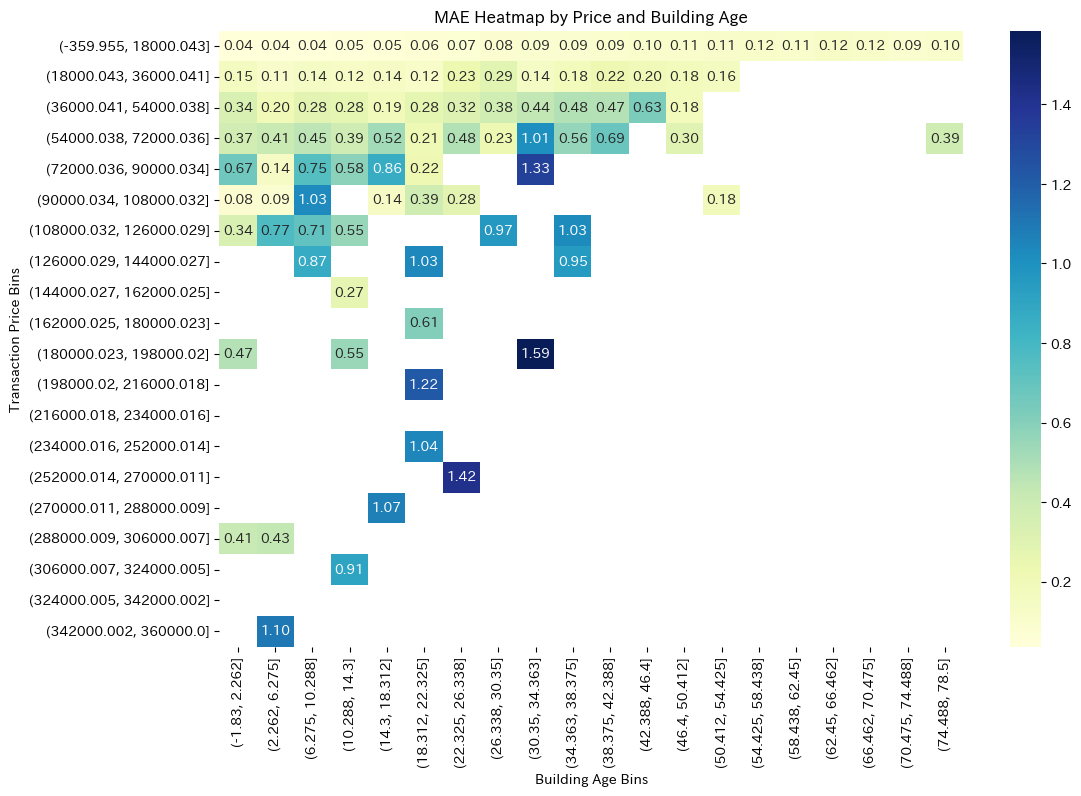

In [15]:
price_bins = pd.cut(train_preds_df['target_price'], bins=20)
age_bins = pd.cut(train_preds_df['購入までの築年数'], bins=20)

heatmap_data = train_preds_df.groupby([price_bins, age_bins])['mae'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Building Age Bins')
plt.ylabel('Transaction Price Bins')
plt.title('MAE Heatmap by Price and Building Age')
plt.show()


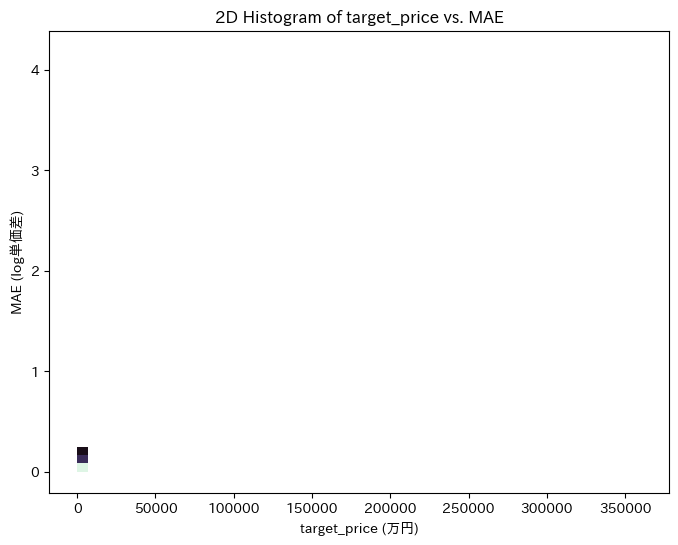

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_preds_df, 
    x='target_price', 
    y='mae', 
    bins=50,        # bin数はデータ量や可読性に合わせて調整
    pthresh=0.05,   # これ以下の頻度は閾値として見えにくくなる
    cmap='mako',    # カラーマップ
)
plt.title('2D Histogram of target_price vs. MAE')
plt.xlabel('target_price (万円)')
plt.ylabel('MAE (log単価差)')
plt.show()


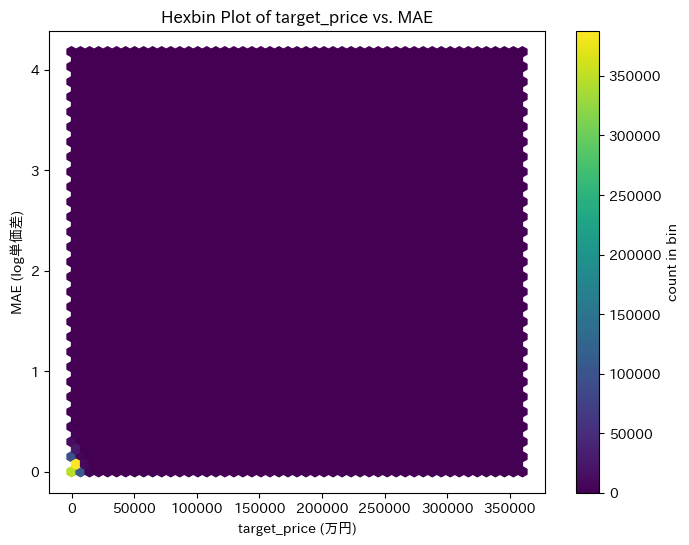

In [17]:
plt.figure(figsize=(8, 6))
plt.hexbin(
    x=train_preds_df['target_price'], 
    y=train_preds_df['mae'], 
    gridsize=50, 
    cmap='viridis'
)
cb = plt.colorbar()
cb.set_label('count in bin')
plt.xlabel('target_price (万円)')
plt.ylabel('MAE (log単価差)')
plt.title('Hexbin Plot of target_price vs. MAE')
plt.show()


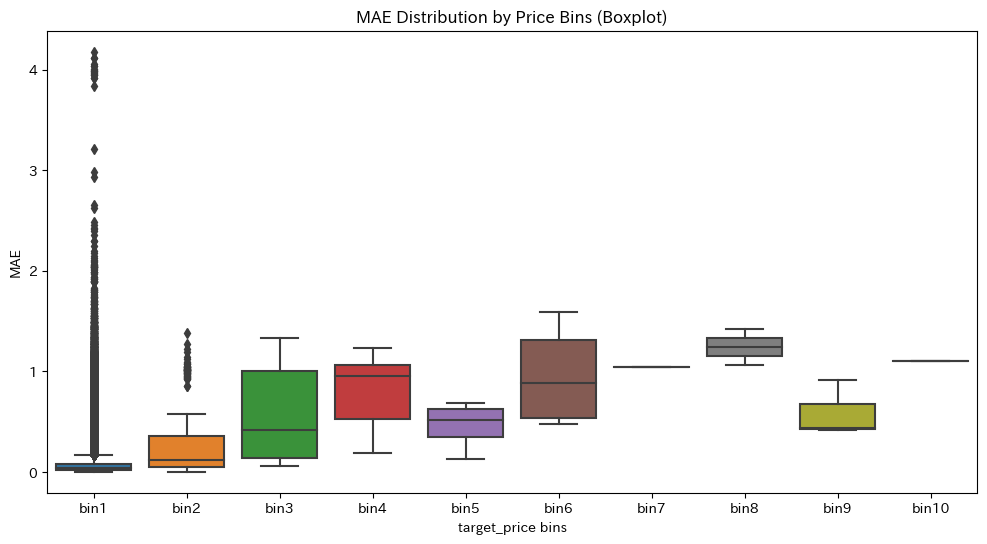

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 例: target_price を等間隔で 10 個にビニング
train_preds_df['price_bin'] = pd.cut(
    train_preds_df['target_price'], 
    bins=10, 
    labels=[f'bin{i}' for i in range(1, 11)]
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_preds_df, x='price_bin', y='mae')
plt.xlabel('target_price bins')
plt.ylabel('MAE')
plt.title('MAE Distribution by Price Bins (Boxplot)')
plt.show()


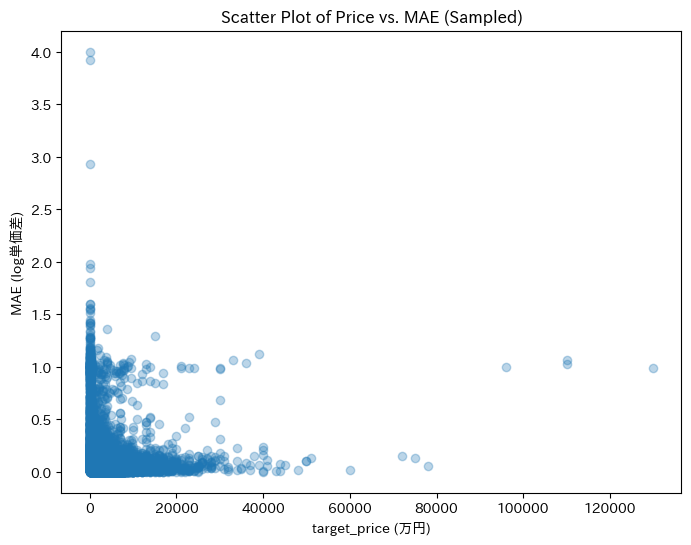

In [19]:
import numpy as np

# 例えば 100,000 レコードをサンプリング
sample_n = 100_000
if len(train_preds_df) > sample_n:
    plot_df = train_preds_df.sample(n=sample_n, random_state=42)
else:
    plot_df = train_preds_df

plt.figure(figsize=(8, 6))
plt.scatter(
    plot_df['target_price'], 
    plot_df['mae'], 
    alpha=0.3
)
plt.xlabel('target_price (万円)')
plt.ylabel('MAE (log単価差)')
plt.title('Scatter Plot of Price vs. MAE (Sampled)')
plt.show()


In [20]:
#print(abc)

In [21]:
train_preds_df["target_price"]=10 ** train_preds_df["target"]
train_preds_df["target_price"]=train_preds_df["target_price"]/10000

In [22]:
train_preds_df["mae"]=abs(train_preds_df["target"]-train_preds_df["pred_weight"])

# 上位10%の誤差が大きい物件
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]


In [23]:
check_dataframe_elements(train_preds_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009270 entries, 1046933 to 47011639
Data columns (total 74 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   価格情報区分                     1009270 non-null  object  
 1   都道府県名                      1009270 non-null  object  
 2   市区町村名                      1009270 non-null  object  
 3   地区名                        1009205 non-null  object  
 4   住所不一致_Flag                 1009270 non-null  int64   
 5   住所                         1009270 non-null  object  
 6   最寄駅：名称                     1009219 non-null  object  
 7   最寄駅：距離（分）                  964321 non-null   float64 
 8   徒歩時間_10分単位                 964321 non-null   float64 
 9   x_api                      1009219 non-null  float64 
 10  y_api                      1009219 non-null  float64 
 11  lon                        998561 non-null   float64 
 12  lat                        998561 non-null   floa

In [24]:
# 誤差が小さい物件の統計
#print(low_error_df.describe())
low_error_describe_df=low_error_df.describe()
#plot1=pd.plotting.scatter_matrix(low_error_df[cols],figsize=(20,20))
#plt.show()

#誤差が小さい物件のMAE
low_error_mae=mean_absolute_error(low_error_df["target"],low_error_df["pred_weight"])
print("MAE low10%",low_error_mae)
#------------------------------------------------------------------------------------

# 誤差が大きい物件の統計
#print(high_error_df.describe())
high_error_describe_df=high_error_df.describe()
#plot2=pd.plotting.scatter_matrix(high_error_df[cols],figsize=(20,20))
#plt.show()

#誤差が大きい物件のMAE
high_error_mae=mean_absolute_error(high_error_df["target"],high_error_df["pred_weight"])
print("MAE high10%",high_error_mae)

MAE low10% 0.003399820678714114
MAE high10% 0.25762216298189977


In [25]:
mae=0.063858
price_log=7.602059991327962
#price_per_area = 10 ** 0.065
#print(price_per_area)

#price_per_area_lower = 10 ** (7.60205999-mae)
#print("予測値下限")
#print(price_per_area_lower)

mae=0.063858
price_per_area = 10 ** price_log
print("取引価格")
print(price_per_area)

# 対数スケールの誤差範囲をもとにした実際の価格の誤差範囲
price_min = price_per_area * (10 ** -mae)
price_max = price_per_area * (10 ** mae)

print("誤差範囲（最小）:", price_min)
print("誤差範囲（最大）:", price_max)
print("±：", price_max-price_per_area)
#price_per_area_upper = 10 ** (7.60205999+mae)
#print("予測値上限")
#print(price_per_area_upper)

#diff=price_per_area_upper-price_per_area_lower
#print(diff)

#print(f"誤差{price_per_area_lower-price_per_area}~{price_per_area_upper-price_per_area}")

取引価格
39999999.999999925
誤差範囲（最小）: 34530430.37920227
誤差範囲（最大）: 46335941.44148508
±： 6335941.441485152


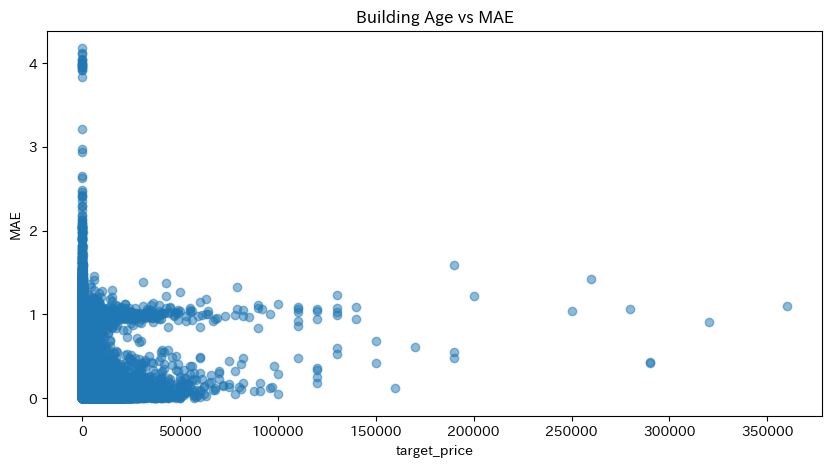

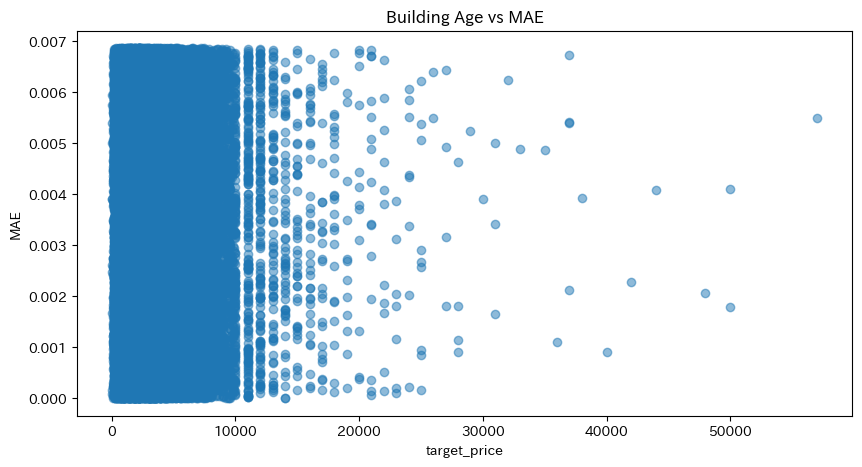

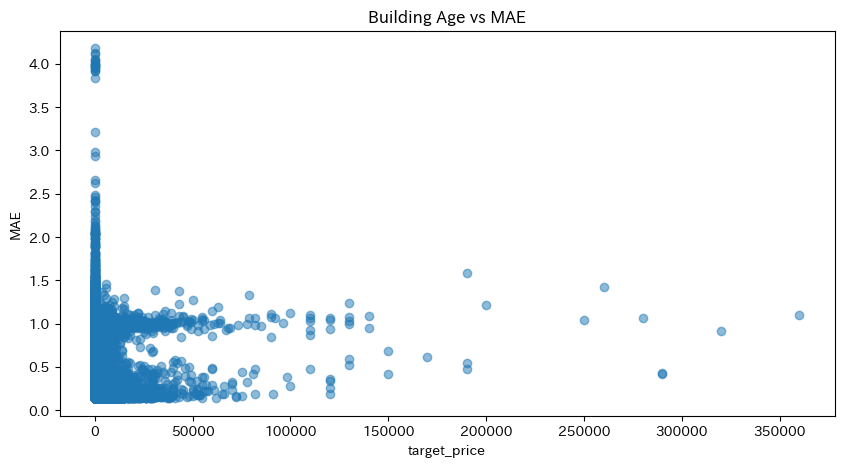

In [26]:
import matplotlib.pyplot as plt

plot_feature="target_price"

# 例: 築年数と誤差の関係を可視化
plt.figure(figsize=(10, 5))
plt.scatter(train_preds_df[plot_feature], train_preds_df['mae'], alpha=0.5)
plt.xlabel(f'{plot_feature}')
plt.ylabel('MAE')
plt.title('Building Age vs MAE')
plt.show()

# 例: 築年数と誤差の関係を可視化
plt.figure(figsize=(10, 5))
plt.scatter(low_error_df[plot_feature], low_error_df['mae'], alpha=0.5)
plt.xlabel(f'{plot_feature}')
plt.ylabel('MAE')
plt.title('Building Age vs MAE')
plt.show()

# 例: 築年数と誤差の関係を可視化
plt.figure(figsize=(10, 5))
plt.scatter(high_error_df[plot_feature], high_error_df['mae'], alpha=0.5)
plt.xlabel(f'{plot_feature}')
plt.ylabel('MAE')
plt.title('Building Age vs MAE')
plt.show()


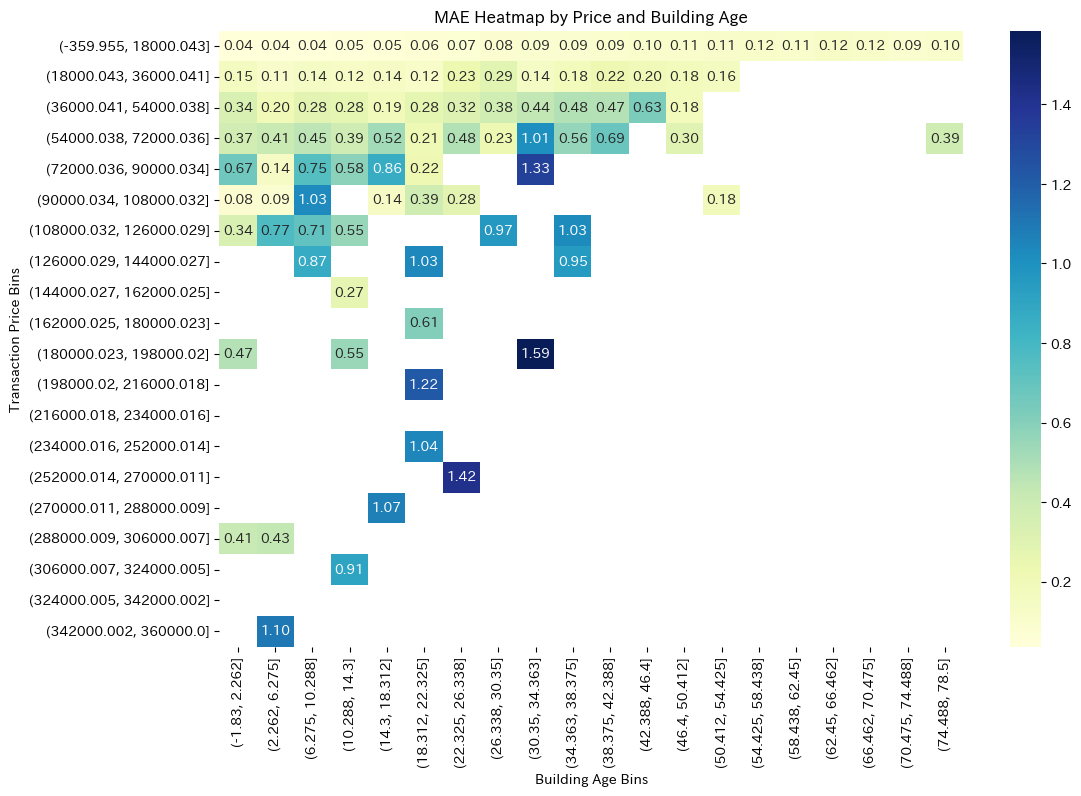

In [27]:
#ヒートマップ

price_bins = pd.cut(train_preds_df['target_price'], bins=20)
age_bins = pd.cut(train_preds_df['購入までの築年数'], bins=20)

heatmap_data = train_preds_df.groupby([price_bins, age_bins])['mae'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Building Age Bins')
plt.ylabel('Transaction Price Bins')
plt.title('MAE Heatmap by Price and Building Age')
plt.show()


In [28]:
# 例: エリアごとの平均MAE
area_mae = train_preds_df.groupby('都道府県名')['mae'].mean().sort_values()
print(area_mae)


都道府県名
東京都     0.052862
島根県     0.058442
大阪府     0.061653
滋賀県     0.061714
京都府     0.063600
神奈川県    0.065150
岡山県     0.066716
佐賀県     0.067007
埼玉県     0.068376
兵庫県     0.070220
沖縄県     0.070398
鹿児島県    0.070687
富山県     0.070718
広島県     0.070936
愛知県     0.071259
宮崎県     0.071446
千葉県     0.072236
愛媛県     0.072273
奈良県     0.072644
宮城県     0.074149
岐阜県     0.074709
福岡県     0.074803
長崎県     0.075700
山口県     0.076314
茨城県     0.076776
三重県     0.078644
山形県     0.078731
熊本県     0.078856
鳥取県     0.078920
大分県     0.079405
香川県     0.080405
福井県     0.081158
北海道     0.081193
秋田県     0.081902
群馬県     0.082815
福島県     0.084170
和歌山県    0.084353
青森県     0.084825
岩手県     0.085592
高知県     0.086213
石川県     0.086760
長野県     0.088321
徳島県     0.090537
山梨県     0.092133
栃木県     0.092206
静岡県     0.097292
新潟県     0.101792
Name: mae, dtype: float64
